# Fingerprint Siamese Neural Network

## Introduction

This is a Siamese Neural Network that compares the similarity between two fingerpints. In the past, this model was trained to compare the similarity between Gabor Enhanced fingerprints ([Fingerprint Siamese NN 2/12/2023](https://denkovarik.github.io/Fingerprint/Experiments/Fingerprint%20Siamese%20Neural%20Network_20230215.html)), which are fingerprints that were enhanced using Gabor filters. The model performed well in doing this by reaching a matching accuracy of over 95% on the validation set. Now the question is this. How well will this model perform on matching the unenhanced fingerprint images?

To answer this, the Fingerprint Siamese Neural Network will be trained to match unenhanced fingerprint images, and it's performance will be tested on a seperate testing set. That dataloader will be modified to allow it to also return the unenhanced fingerprint pairs in addition to the enhanced versions. This model will be trained in 3 stages. In the first stage, the model will be trained to match the enhanced fingerprint pair versions just as before. This will allow the subnetwork to learn how to extract the features from good quality fingerprints. Next the model will be trained to match unenhanced good fingerprints to enhance fingerprint images. The hope is that this will help the network bridge the gap between matching enhanced fingerprint pairs to unenhanced fingerprint pairs. Finally, the model will be trained to match unenhanced fingerprint pairs of varying qualities (from really good to really bad).

This Siamese Neural Network was adapted from https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py for comparing images of characters. This model will be trained on a dataset of synthetically generated fringerprints using the [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/) software.

This model was run on 2/27/2023.


## Install Dependencies

In [1]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-image
%reload_ext autoreload
%autoreload

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from torchvision import transforms
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv

import os
import re
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise

from IPython.display import HTML
import matplotlib.animation as animation
from collections import defaultdict


## Config

In [19]:
model_results_file = "checkpoint/SSNN_results.pt"
model_ckpt_file = "checkpoint/SSNN_checkpoint.pt"

data_base_dir = "../Datasets/Fingerprint_databases/"

im_size = (300, 206)
var_max = 0.5

num_train = 10000
num_valid = 4000
num_workers = 1
shuffle = True
augment = True

sim_label = 1.0
diff_label = 0.0

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of feature maps in Siamese Neural Network
ndf = 64

# Learning rate for optimizers
slr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Utils

In [28]:
def saveCkpt(filepath, epoch, netS, optimizerS, S_losses, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netS_state_dict' : netS.state_dict(),
        'optimizerS_state_dict' : optimizerS.state_dict(),
        'S_losses' : S_losses,
        'iters' : iters,
    }, filepath)


def showSampleFingerprintPairs(test_loader):
    # Get a Batch of Sample Images
    batch = next(iter(test_loader))
    labels = batch[2][:8]
    
    # Display the Sample Images
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()

    c = 0
    if labels is not None:
        for l in labels:
            if l == 1:
                print("     same     ", end="")
            else:
                print("     diff     ", end="")
            if c % 4 == 0:
                print(" ", end="")
            c += 1
            
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

In [29]:
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
   
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    return (train_loader)

def get_train_valid_test_loaders(target_dir, template_dir,
                                 batch_size,
                                 num_train,
                                 num_valid,
                                 shuffle=False,
                                 num_workers=2,
                                 pin_memory=False):
    """
    Utility function for loading and returning train and valid
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    # Each unique Fingerprint is named as a number from 1 to 10,000 (10000 unique fingerprints)
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7000]
    validation_prints = fingerprints[7000:9500]
    test_prints = fingerprints[9500:]
   
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    # Get the Validation Dataloader
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints, batch_size)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
   
    # Get the Test Dataloader
    test_dataset = FingerprintLoader(target_dir, template_dir, num_valid, test_prints, batch_size)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    return (train_loader, valid_loader, test_loader)

In [30]:
class FingerprintLoader(Dataset):
    """
    This class is used to help load the fingerprint dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset, batch_size):
        """
        Initializes an instance for the FingerprintLoader class.
        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = set(dataset)  # Convert to set for faster lookup
        self.num_train = num_train
        self.augment = augment
        self.batch_size = batch_size
        
        # Precompute paths by fingerprint ID for target
        self.target_paths_by_id = defaultdict(list)
        for root, dirs, files in os.walk(self.target_dataset):
            for file in files:
                if file.endswith('.jpg'):
                    name = file[:-4]  # Remove '.jpg'
                    match = re.search(r'\d+', name)
                    if match:
                        finger_id = str(int(match.group(0)))
                        if finger_id in self.fingerprints_dataset:
                            fullpath = os.path.join(root, file)
                            self.target_paths_by_id[finger_id].append(fullpath)
        
        # Precompute paths by fingerprint ID for template
        self.template_paths_by_id = defaultdict(list)
        for root, dirs, files in os.walk(self.template_dataset):
            for file in files:
                if file.endswith('.jpg'):
                    name = file[:-4]  # Remove '.jpg'
                    match = re.search(r'\d+', name)
                    if match:
                        finger_id = str(int(match.group(0)))
                        if finger_id in self.fingerprints_dataset:
                            fullpath = os.path.join(root, file)
                            self.template_paths_by_id[finger_id].append(fullpath)
        
        # Get list of available IDs (those with at least one path)
        self.target_ids = list(self.target_paths_by_id.keys())
        self.template_ids = list(self.template_paths_by_id.keys())
        
        # Ensure there are available fingerprints
        if not self.target_ids or not self.template_ids:
            raise ValueError("No valid fingerprint images found in the datasets for the given fingerprints.")

    def __len__(self):
        """
        Helper function to return the length of the dataset
        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset. This function will choose a
        fingerprint image from the dataset and its corresponding enhanced fingerprint image.
        It will then preprocess the images before returning them.
        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        target_im_filepath, template_im_filepath, y = self.chooseFingerprintPair()
        targ_im = self.preprocessImage(target_im_filepath)
        temp_img = self.preprocessImage(template_im_filepath)
        y = torch.from_numpy(np.array([y], dtype=np.float32))
        return targ_im, temp_img, y

    def chooseFingerprintPair(self):
        """
        Returns the filepath of the target fingerprint image and the enhanced template fingerprint.
        :param self: instance of the FingerprintLoader class
        :return: The filepaths for the pair and the label y
        """
        # Choose if same or different (50% chance, matching original randint(0,1))
        y = float(random.randint(0, 1))
        
        # Choose target ID and path
        target_id = random.choice(self.target_ids)
        target_im_filepath = random.choice(self.target_paths_by_id[target_id])
        
        # Choose template ID
        if y == 1.0:  # same
            template_id = target_id
        else:  # different
            template_id = random.choice(self.template_ids)
            while template_id == target_id and len(self.template_ids) > 1:
                template_id = random.choice(self.template_ids)
        
        template_im_filepath = random.choice(self.template_paths_by_id[template_id])
        
        return target_im_filepath, template_im_filepath, y

    def preprocessImage(self, im_filepath):
        """
        Preprocesses the image. This function will open the image, convert 
        it to grayscale, pad the image in order to make is square, 
        normalize the image, and then finally convert it to a tensor.
        :param im: Filepath of the image to preprocess
        :return: The preprocessed image
        """
        im = Image.open(im_filepath)
        # Convert to Grayscale
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        preprocessedImage = trans(im)
        return preprocessedImage

## Weight Initialization

In [31]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Siamese Neural Network

In [32]:
class SiameseNet(nn.Module):
    """
    A Convolutional Siamese Network for One-Shot Learning [1].
    Siamese networts learn image representations via a supervised metric-based
    approach. Once tuned, their learned features can be leveraged for one-shot
    learning without any retraining.
    References
    ----------
    https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py
    - Koch et al., https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    """
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(1225, 512)
        self.fc2 = nn.Linear(805, 1)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.
        Args
        ----
        - x: Contains either the first or second image pair across the input batch.
        Returns
        -------
        - out: The hidden vector representation of the input vector x.
        """
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        return out

    def forward(self, x1, x2):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.
        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.
        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.
        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)
        
        # score the similarity between the 2 encodings
        scores = torch.sigmoid(self.fc2(diff))

        return scores

In [33]:
# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)

# Print the model
print(netS)

SiameseNet(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1225, out_features=512, bias=True)
  (fc2): Linear(in_features=805, out_features=1, bias=True)
)


## Training Round 1

The model will first be trained to match the enhanced fingerprint pair versions just as before. This will allow the subnetwork to learn how to extract the features from good quality fingerprints. 

### Set Training Params

In [34]:
# create data loaders
torch.manual_seed(1)
batch_size = 64

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"

# Create the dataloader
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 1

### Data Visualization

It was difficult to get access to large enough fingerprint datasets for training. This is because fingerprints are considered personal information, so this data is not commonly avaiable to everyone. Because of this, I ended up having to synthetically generate my own dataset using the [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/) software. This generated dataset contains close to one million fingerprint images of varying qualities, which includes around 10,000 unique fingerprints. 

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on, which is a subset of the dataset containing around 100,000 enhanced images of the good quality synthetic fingerprints in the datase.


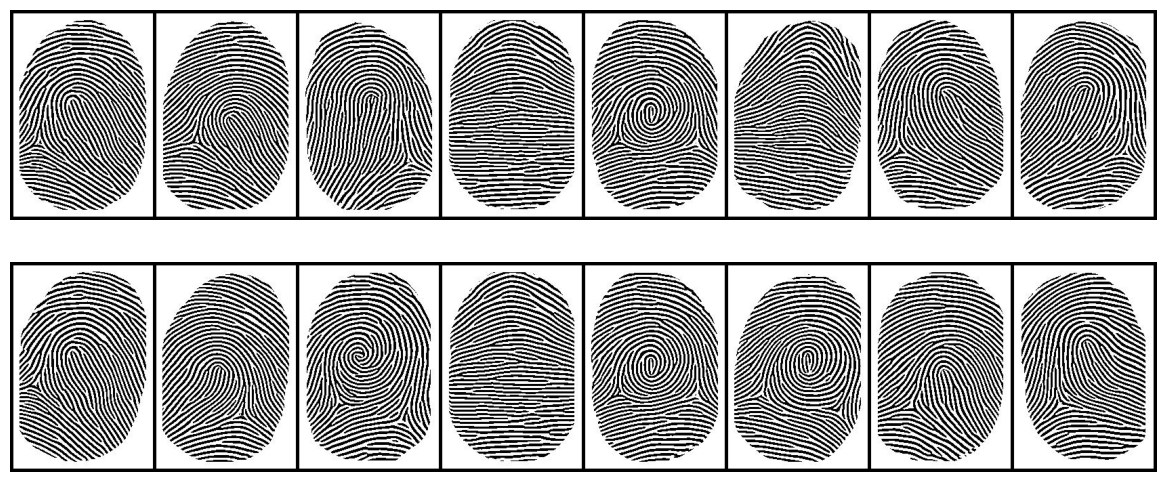

     same           diff          diff          same          same           diff          diff          diff     

In [35]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [36]:
# Train
def train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device, S_losses = []):
    start_epoch = 1
    # Lists to keep track of progress
    iters = 0

    print("\n[*] Train on {} sample pairs, validate on {} sample pairs".format(
        num_train, num_valid)
    )

    gLossMvAvg = MovingAvg()

    for epoch in range(start_epoch, num_epochs+1):
        print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
        # switch to train mode
        netS.train()
        train_batch_time = AverageMeter()
        train_losses = AverageMeter()
        tic = time.time()
        training_accuracy = 0.0
        num_correct = 0
        total = 0
        with tqdm(total=num_train) as pbar:
            for i, (x1, x2, y) in enumerate(train_loader): 
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                output = netS(x1, x2).view(-1)
                y = y.view(-1)
                errS = criterion(output, y)
                # Calculate the gradients for this batch
                errS.backward()
                # Update S
                optimizerS.step()

                for i in range(len(output)):
                    label = 0.0
                    if output[i] > 0.5:
                        label = 1.0
                    if label == y[i]:
                        num_correct += 1
                    total += 1

                training_accuracy = num_correct / total * 100

                # store batch statistics
                toc = time.time()
                train_batch_time.update(toc-tic)
                tic = time.time()
                pbar.set_description(
                    (
                        "loss_S: {:.3f}   training accuracy: {:.6f}".format(errS.item(), training_accuracy)
                    )
                )
                pbar.update(batch_size)

                # Save Losses for plotting later
                S_losses.append(errS.item())
                iters +=1

        # Validate
        netS.eval()
        validation_accuracy = 0.0
        num_valid_correct = 0
        total_valid = 0
        for i, (x1, x2, y) in enumerate(valid_loader): 
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            output = netS(x1, x2).view(-1)
            y = y.view(-1)

            for i in range(len(output)):
                label = 0.0
                if output[i] > 0.5:
                    label = 1.0
                if label == y[i]:
                    num_valid_correct += 1
                total_valid += 1

        validation_accuracy = num_valid_correct / total_valid * 100
        print("Validataion Accuracy:  {:.6f}".format(validation_accuracy))
    
    saveCkpt(model_results_file, 1, netS, optimizerS, S_losses, iters)    
    return S_losses
        

In [37]:
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 10000 sample pairs, validate on 4000 sample pairs

Epoch: 1/1


loss_S: 0.206   training accuracy: 74.930000: : 10048it [00:21, 464.33it/s]                                                                                                                   


Validataion Accuracy:  89.850000


## Training Round 2

Next the model will be trained to match unenhanced good fingerprints to enhance fingerprint images. The hope is that this will help the network bridge the gap between matching enhanced fingerprint pairs to unenhanced fingerprint pairs.

### Set Training Params

In [39]:
# create data loaders
torch.manual_seed(1)
batch_size = 64

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Good/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"

# Create the dataloader
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 1

### Data Visualization

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on. The top row consists of the unenhanced good quality fingerprints, which is a subset of the dataset consisting of around 100,000 fingerprint images with 10,000 unique fingerprints. The bottom row consists of the enhanaced fingerprint images, which is a different subset of the dataset that also consists of around 100,000 fingerprint images containing the same 10,000 unique fingerprints as the perviously described subset. Please note that the enhanced fingerprint subset was generated from the unenhanced good fingerprint subset using Gabor Filters. 

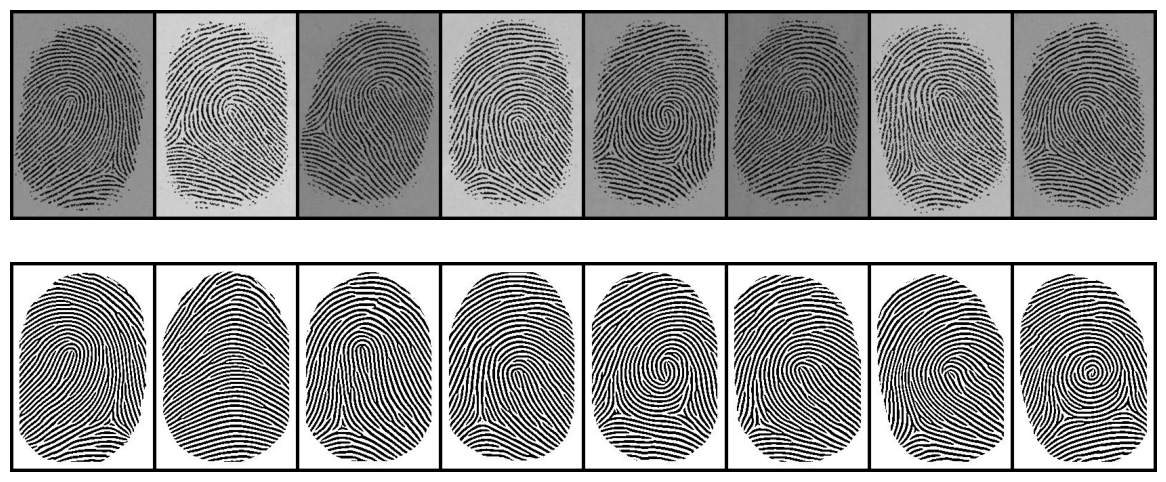

     same           diff          diff          same          same           diff          diff          diff     

In [40]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [41]:
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 10000 sample pairs, validate on 4000 sample pairs

Epoch: 1/1


loss_S: 0.439   training accuracy: 95.660000: : 10048it [00:21, 477.91it/s]                                                                                                                   


Validataion Accuracy:  93.175000


## Training Round 3

Finally, the model will be trained to match unenhanced fingerprint pairs of varying qualities (from really good to really bad).

### Set Training Params

In [43]:
# create data loaders
torch.manual_seed(1)
batch_size = 256

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Bad/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Bad/"

# Create the dataloader
num_train = 100000
num_valid = 4000
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 15

### Data Visualization

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on, which is a larger subset containing around 800,000 unenhanced fingerprint images of varying qualityies from really good to really bad.

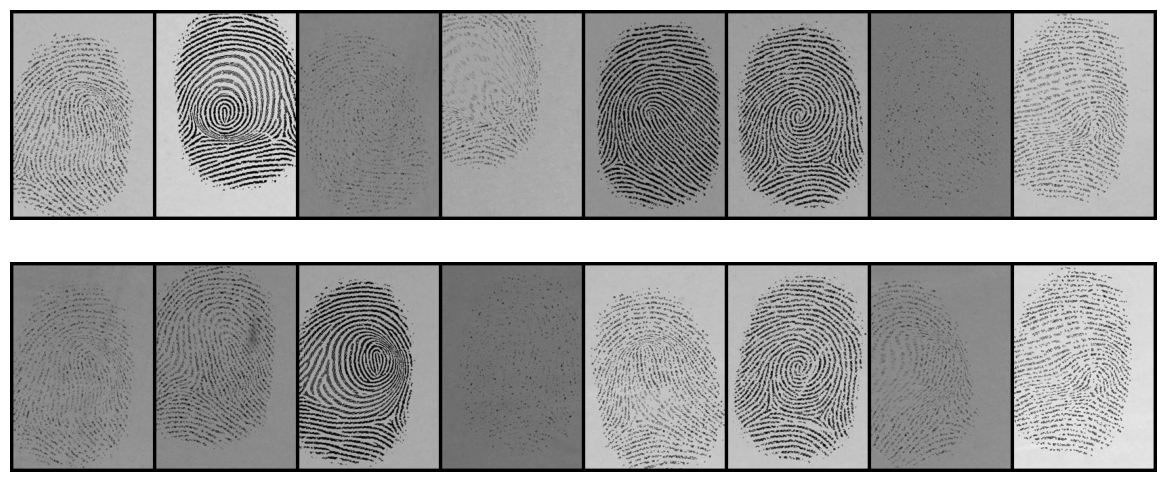

     same           diff          diff          same          diff           same          diff          same     

In [44]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [45]:
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 1/15


loss_S: 0.384   training accuracy: 71.940000: : 100096it [03:21, 495.56it/s]                                                                                                                  


Validataion Accuracy:  80.850000

Epoch: 2/15


loss_S: 0.249   training accuracy: 86.408000: : 100096it [03:20, 498.80it/s]                                                                                                                  


Validataion Accuracy:  89.475000

Epoch: 3/15


loss_S: 0.181   training accuracy: 92.065000: : 100096it [03:20, 498.85it/s]                                                                                                                  


Validataion Accuracy:  93.525000

Epoch: 4/15


loss_S: 0.199   training accuracy: 93.410000: : 100096it [03:20, 498.45it/s]                                                                                                                  


Validataion Accuracy:  94.200000

Epoch: 5/15


loss_S: 0.155   training accuracy: 94.070000: : 100096it [03:22, 494.39it/s]                                                                                                                  


Validataion Accuracy:  92.875000

Epoch: 6/15


loss_S: 0.238   training accuracy: 94.235000: : 100096it [03:26, 485.32it/s]                                                                                                                  


Validataion Accuracy:  93.350000

Epoch: 7/15


loss_S: 0.143   training accuracy: 94.540000: : 100096it [03:21, 497.04it/s]                                                                                                                  


Validataion Accuracy:  94.875000

Epoch: 8/15


loss_S: 0.070   training accuracy: 94.828000: : 100096it [03:21, 497.29it/s]                                                                                                                  


Validataion Accuracy:  95.125000

Epoch: 9/15


loss_S: 0.156   training accuracy: 95.339000: : 100096it [03:23, 492.02it/s]                                                                                                                  


Validataion Accuracy:  94.975000

Epoch: 10/15


loss_S: 0.162   training accuracy: 95.420000: : 100096it [03:08, 530.33it/s]                                                                                                                  


Validataion Accuracy:  95.325000

Epoch: 11/15


loss_S: 0.146   training accuracy: 95.135000: : 100096it [03:05, 538.53it/s]                                                                                                                  


Validataion Accuracy:  94.425000

Epoch: 12/15


loss_S: 0.071   training accuracy: 95.402000: : 100096it [03:11, 522.52it/s]                                                                                                                  


Validataion Accuracy:  96.250000

Epoch: 13/15


loss_S: 0.147   training accuracy: 95.735000: : 100096it [03:20, 498.42it/s]                                                                                                                  


Validataion Accuracy:  95.450000

Epoch: 14/15


loss_S: 0.140   training accuracy: 95.377000: : 100096it [03:21, 496.79it/s]                                                                                                                  


Validataion Accuracy:  95.100000

Epoch: 15/15


loss_S: 0.050   training accuracy: 95.240000: : 100096it [03:13, 517.60it/s]                                                                                                                  


Validataion Accuracy:  95.375000


## Results

### Training Loss

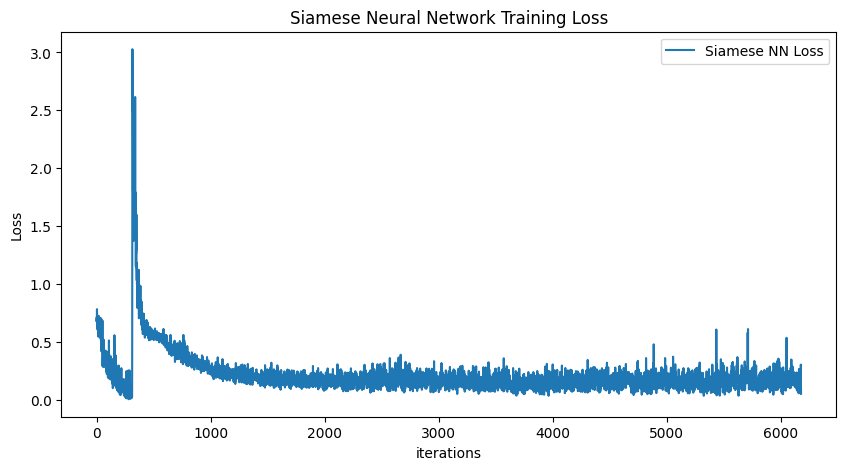

In [46]:
def plotTrainingLoss(S_losses):
    plt.figure(figsize=(10,5))
    plt.title("Siamese Neural Network Training Loss")
    plt.plot(S_losses,label="Siamese NN Loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
plotTrainingLoss(S_losses)

## Sample Performance
Below is plotted 8 pairs of fingerprints. Below each pair of fingerprints, the model will gives its prediction of whether each pair are of the same fingerprint or not. Below that is listed the ground truth.

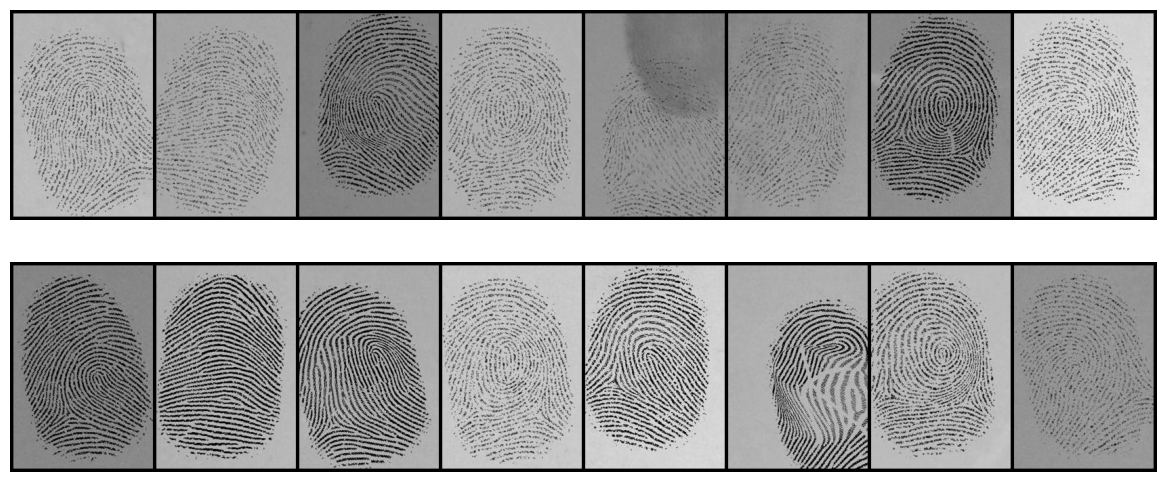

Pred: 
      diff           same          same          same          same           diff          diff          same    

Truth:
      diff           same          same          same          same           diff          diff          same    

Matching Accuracy over Test Dataset: 95.73%


In [47]:
def printLabels(labels):
    c = 0
    for l in labels:
        if l == 1:
            print("      same    ", end="")
        else:
            print("      diff    ", end="")
        if c % 4 == 0:
            print(" ", end="")
        c += 1
    print("\n")
    
    
def test(netS, loader, device):
    # Validate
    netS.eval()
    validation_accuracy = 0.0
    num_valid_correct = 0
    total_valid = 0
    for i, (x1, x2, y) in enumerate(loader): 
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        output = netS(x1, x2).view(-1)
        y = y.view(-1)

        for i in range(len(output)):
            label = 0.0
            if output[i] > 0.5:
                label = 1.0
            if label == y[i]:
                num_valid_correct += 1
            total_valid += 1

    validation_accuracy = num_valid_correct / total_valid * 100
    print("Matching Accuracy over Test Dataset: {:.2f}%".format(validation_accuracy))
    

def showTestPerformance(netS, test_loader, device):
    batch = next(iter(test_loader))
    labels = batch[2][:8]

    # Let model make predictions
    netS.eval()
    output = netS(batch[0].to(device)[:8], batch[1].to(device)[:8]).view(-1)

    # Display the Sample Images
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()


    # Display Model Performance
    preds = [0 if x < 0.5 else 1 for x in output]

    print("Pred: ")
    printLabels(preds)

    print("Truth:")
    printLabels(labels)  
    
    test(netS, test_loader, device)
    
showTestPerformance(netS, test_loader, device)


## Conclusion

The performance of the Fingerprint Siamese Neural Network turned out better than expected. It achieved a test accuracy of 93%, which is really suprising considering that the dataset contains some really bad fingerprint impressions. It could be that the model was able to exploit some artifact found in the generated fingerprints. Only testing this model on a dataset of real fingerprints would tell for sure though.

If it is not the case that the model is exploiting some artifact found in the syntheically generated fingerprints, then it appears that the subnetwork is able to reliably extract the features from these unenhanced fingerprint impressions. Maybe this trained subnetwork could be used in training the GAN? It could be possible to use the trained Fingerprint Siamese Neural Network subnetwork to produce a latent vector of fingerprint features that the GAN would then use to generate images of fingerprints from. This would allow for the generator to have a much shallower network, which would simplify it's network architecture and possibly help avoid mode collapse.